# Archetypal Dog Names

Data from here: https://www.kaggle.com/kingburrito666/largest-dog-breed-data-set/data

We calculate an odds ratio for each name and breed, and use Fisher's 

In [1]:
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt

% matplotlib inline


In [2]:
years = [pd.read_csv('../dog_name_data/%d.csv' % year) for year in range(2007, 2018)]

df = pd.concat(years)

df.DogName = df.DogName.apply(str.upper)

In [3]:
df['breed_no_mix'] = df.Breed.str.rstrip(' MIX')
df['breed_no_mix'] = df.breed_no_mix.replace('LAB', 'LABRADOR RETRIEVER')

In [4]:
breed_counts = df.groupby('breed_no_mix')['DogName'].count()
name_counts = df.groupby('DogName')['breed_no_mix'].count()

main_breeds = df[(df.breed_no_mix.map(breed_counts.to_dict()) > 500) 
                 & ~(df.Breed.isin(['MIXED', 'OTHER']))
                & (df.DogName.map(name_counts.to_dict()) > 100)]

In [5]:
names_by_breed = main_breeds.groupby(['breed_no_mix', 'DogName'])['LicenseType'].count()
names = main_breeds.groupby('DogName')['DogName'].count()
breeds = main_breeds.groupby('breed_no_mix')['breed_no_mix'].count()
tabulated = pd.DataFrame(names_by_breed).join(names).join(breeds)
tabulated.columns = ['name_in_breed', 'name_total', 'breed_total']
tabulated['total_dogs'] = len(main_breeds)
tabulated['name_not_breed'] = tabulated.name_total - tabulated.name_in_breed
tabulated['breed_not_name'] = tabulated.breed_total - tabulated.name_in_breed
tabulated['not_name_not_breed'] = tabulated.total_dogs - tabulated.name_not_breed
tabulated['breed_odds'] = tabulated.name_in_breed/tabulated.breed_not_name
tabulated['not_breed_odds'] = tabulated.name_not_breed/tabulated.not_name_not_breed
tabulated['odds_ratio'] = tabulated.breed_odds/tabulated.not_breed_odds

In [7]:
def apply_fisher(row):
    ratio, p_value = fisher_exact([[row.name_in_breed, row.name_not_breed],
                            [row.breed_not_name, row.not_name_not_breed]])
    return p_value


tabulated['p_value'] = tabulated.apply(apply_fisher,
                            axis=1
                            )

In [30]:
tabulated[tabulated.p_value < 0.05].sort_values(by='odds_ratio', ascending=False).head(20)

name_in_breed  name_total  breed_total  \
breed_no_mix        DogName                                            
CHIHUAHUA           CHI CHI              92         113         5046   
DALMATIAN           DOMINO               21         100          380   
AM ESKIMO DOG       SNOWBALL             22         154          384   
ITALIAN GREYHOUND   PATCH                 8          74          278   
SCOTTISH TERRIER    DUNCAN               14         158          288   
                    ANGUS                12         141          288   
WELSH CORGI PEMBROK CORKY                11          85          481   
DALMATIAN           SPOT                  9          89          380   
AM STAFF TERRIER    SWEETIE              10         127          295   
AM ESKIMO DOG       ISIS                  8          81          384   
BULLMASTIFF         RED                   7          91          303   
DALMATIAN           BLAZE                23         255          380   
ENG SETTER          PATCH                 8          74          462   
ITALIAN GREYHOUND   JORDAN                6          89          278   
CHIHUAHUA           CHICO               213         383         5046   
SCOTTISH TERRIER    PIPER                18         276          288   
POMERANIAN          FOXY                 48         139         2092   
SHIBA INU           NO NAME               4          52          329   
BULLMASTIFF         GIGI                  9         135          303   
BERNESE MTN DOG     SID                   7          98          345   

                              total_dogs  name_not_breed  breed_not_name  \
breed_no_mix        DogName                                                
CHIHUAHUA           CHI CHI       151334              21            4954   
DALMATIAN           DOMINO        151334              79             359   
AM ESKIMO DOG       SNOWBALL      151334             132             362   
ITALIAN GREYHOUND   PATCH         151334              66             270   
SCOTTISH TERRIER    DUNCAN        151334             144             274   
                    ANGUS         151334             129             276   
WELSH CORGI PEMBROK CORKY         151334              74             470   
DALMATIAN           SPOT          151334              80             371   
AM STAFF TERRIER    SWEETIE       151334             117             285   
AM ESKIMO DOG       ISIS          151334              73             376   
BULLMASTIFF         RED           151334              84             296   
DALMATIAN           BLAZE         151334             232             357   
ENG SETTER          PATCH         151334              66             454   
ITALIAN GREYHOUND   JORDAN        151334              83             272   
CHIHUAHUA           CHICO         151334             170            4833   
SCOTTISH TERRIER    PIPER         151334             258             270   
POMERANIAN          FOXY          151334              91            2044   
SHIBA INU           NO NAME       151334              48             325   
BULLMASTIFF         GIGI          151334             126             294   
BERNESE MTN DOG     SID           151334              91             338   

                              not_name_not_breed  breed_odds  not_breed_odds  \
breed_no_mix        DogName                                                    
CHIHUAHUA           CHI CHI               151313    0.018571        0.000139   
DALMATIAN           DOMINO                151255    0.058496        0.000522   
AM ESKIMO DOG       SNOWBALL              151202    0.060773        0.000873   
ITALIAN GREYHOUND   PATCH                 151268    0.029630        0.000436   
SCOTTISH TERRIER    DUNCAN                151190    0.051095        0.000952   
                    ANGUS                 151205    0.043478        0.000853   
WELSH CORGI PEMBROK CORKY                 151260    0.023404        0.000489   
DALMATIAN           SPOT                  151254    

In [44]:
tabulated[tabulated.p_value < 0.05].xs('BILLIE', level='DogName').sort_values(by='odds_ratio', ascending=False).head(10)

KeyError: 'BILLIE'

In [10]:
df['terminal_y'] = df.DogName.apply(lambda x: x[-1] == 'Y' or x[-2:] == 'IE')

In [11]:
y_counts = df[df.breed_no_mix.map(breed_counts.to_dict()) > 4000].groupby('breed_no_mix')['terminal_y'].mean().sort_values()

In [33]:
y_counts.index = [name.title() for name in y_counts.index]

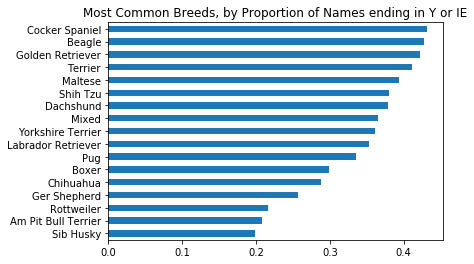

In [40]:
y_counts.plot(kind='barh')
plt.title('Most Common Breeds, by Proportion of Names ending in Y or IE')
plt.savefig('terminal_y.png', bbox_inches='tight')
plt.show()